In [1]:
# Importing Libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from pypalettes import load_cmap
import numpy as np
from shapely.geometry import Point
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap

In [3]:

# Function to interpolate the colormap with cubic interpolation
def interpolate_cmap(cmap, num_interp_points):
    new_colors = cmap(np.linspace(0, 1, cmap.N))  # Ottieni i colori della colormap discreta
    new_cmap = LinearSegmentedColormap.from_list('my_interpolated_cmap', new_colors, N=num_interp_points)
    return new_cmap


In [5]:
# Reading ShapeFiles and projectig them in web Mercator

reservoirs = gpd.read_file('reservoir.shp')
basin = gpd.read_file('3Sbasin.shp')
rivernetwork = gpd.read_file('rivernetwork.shp')
sesan = gpd.read_file('sesan.shp')
srepok = gpd.read_file('srepok.shp')
sekong = gpd.read_file('sekong.shp')
mekong = gpd.read_file('MekongBasin.shp')
mekong1 = gpd.read_file('mekong_basin.geojson')
mekongriver=gpd.read_file('Mekong_River_Full.shp')

reservoirs = reservoirs.to_crs(epsg=3857)
basin = basin.to_crs(epsg=3857)
rivernetwork = rivernetwork.to_crs(epsg=3857)
sesan = sesan.to_crs(epsg=3857)
sekong = sekong.to_crs(epsg=3857)
srepok = srepok.to_crs(epsg=3857)
mekong = mekong.to_crs(epsg=3857)
mekong1 = mekong1.to_crs(epsg=3857)
mekongriver = mekongriver.to_crs(epsg=3857)
mekong2 = gpd.GeoDataFrame(pd.concat([mekong, mekong1], ignore_index=True), crs=mekong.crs)


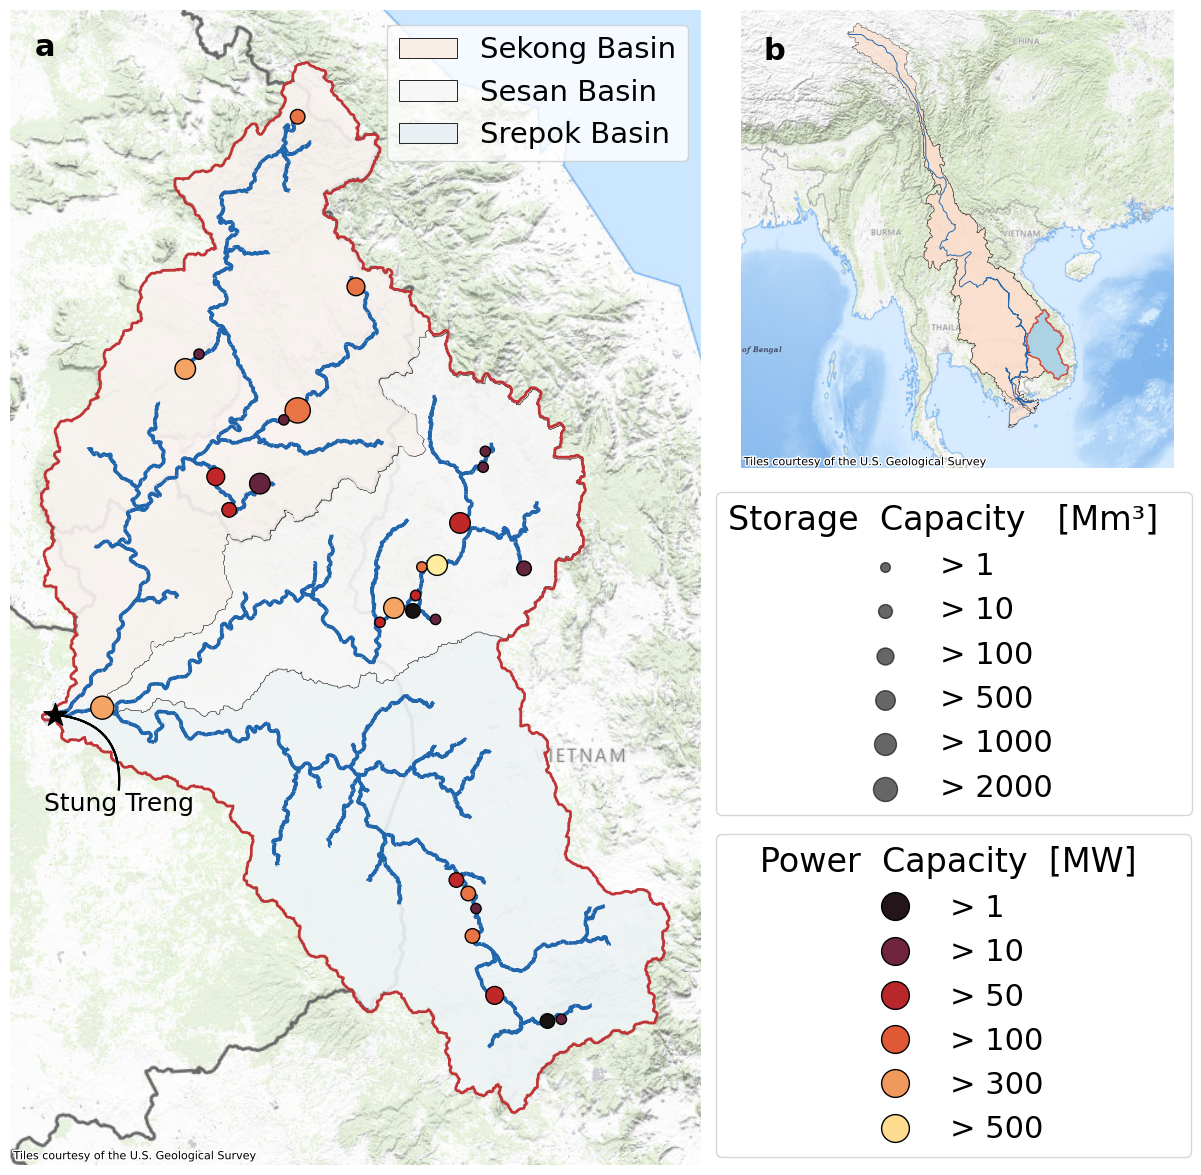

In [6]:
# Plot of Figure 1
# Defining the classes for storage capacity and the corresponding bubble sizes
def get_bubble_size(storagecapacity):
    if storagecapacity <= 10:
        return 10
    elif storagecapacity <= 100:
        return 20
    elif storagecapacity <= 500:
        return 30
    elif storagecapacity <= 1000:
        return 40
    elif storagecapacity <= 2000:
        return 50
    else:
        return 60
def get_color(powercapacity):
    cmap1 = load_cmap("Exter")
    if powercapacity <= 10:
        return cmap1(0.96)
    elif powercapacity <= 50:
        return cmap1(0.75)
    elif powercapacity <= 100:
        return cmap1(0.57)
    elif powercapacity <= 300:
        return cmap1(0.39)
    elif powercapacity <= 500:
        return cmap1(0.25)
    else:
        return cmap1(0.015)
reservoirs['bubble_size'] = reservoirs['storagecap'].apply(get_bubble_size)
cmap1 = load_cmap("Exter")
cmap1 = interpolate_cmap(cmap1, 1000)
reservoirs['bubble_color'] = reservoirs['powercapac'].apply(get_color)
# Set the plot size
fig, ax = plt.subplots(figsize=(10, 15))
ax.axis('off')  

cmap = load_cmap("BuRd")
cmap = interpolate_cmap(cmap, 1000)



srepok.plot(ax=ax, facecolor=cmap(0.47, alpha=0.9),label='Srepok Sub-basin')
sesan.plot(ax=ax, facecolor=cmap(0.50, alpha=0.9),edgecolor='black',linewidth=0.4 , label='Sesan Sub-basin')
sekong.plot(ax=ax, facecolor=cmap(0.52,alpha=0.9),label='Sekong Sub-basin')
basin.plot(ax=ax, facecolor="none", edgecolor=cmap(0.95),linewidth=2)

rivernetwork.plot(ax=ax, color=cmap(0),linewidth=2.5,zorder=1)
# For the bubble plot, use the 'markersize' parameter with the 'storagecapacity' column
reservoirs.plot(ax=ax, markersize=reservoirs['bubble_size']*5.5, color=reservoirs['bubble_color'],edgecolor='black',zorder=2)
# Adding a map
#ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),zoom = 10,source=ctx.providers.CartoDB.Positron) #
ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.USGS.USTopo) 
leftmost_coords = rivernetwork.bounds['minx'].min()
topmost_coords = rivernetwork.bounds['maxy'].max()
leftmost_minx=leftmost_coords
y_value = rivernetwork[rivernetwork['geometry'].apply(lambda geom: geom.bounds[0] == leftmost_minx)].geometry.centroid.y.iloc[0]
stung_treng_coords = (leftmost_coords + 70000, np.mean(rivernetwork.bounds['miny'])-100000)  
ax.text(stung_treng_coords[0], stung_treng_coords[1], 'Stung Treng', fontsize=18, ha='right')

ax.text(leftmost_coords, topmost_coords+30000, 'a', fontsize=22, ha='right',fontweight='bold')

ax.scatter(leftmost_coords, y_value, marker='*', color='black', s=300)

import matplotlib.patches as patches
def add_arrow(head_pos, tail_pos, ax):
    style = "Simple, tail_width=0.1, head_width=1, head_length=1"
    kw = dict(arrowstyle=style, color="k", linewidth=1.5)
    arrow = patches.FancyArrowPatch(
        tail_pos, head_pos,
        connectionstyle="arc3,rad=.5",
        **kw
    )
    ax.add_patch(arrow)
add_arrow( (leftmost_coords, y_value),(stung_treng_coords[0]-38000, stung_treng_coords[1]+9000),ax) # mean


legend_patches = [
    plt.Rectangle((0, 0), 1, 1, fc=cmap(0.54, alpha=1), edgecolor='black',linewidth=0.6),
    plt.Rectangle((0, 0), 1, 1, fc=cmap(0.50, alpha=0.9), edgecolor='black',linewidth=0.6),
    plt.Rectangle((0, 0), 1, 1, fc=cmap(0.45, alpha=1), edgecolor='black',linewidth=0.6)
    
]
legend_labels = ['Sekong Basin', 'Sesan Basin', 'Srepok Basin']
leg1 = ax.legend(legend_patches, legend_labels, loc='upper left', bbox_to_anchor=(0.525, 1), fontsize=21, title_fontsize=24)
ax.add_artist(leg1)

power_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markeredgecolor='black', markersize=20) 
                         for color in [cmap1(0.96), cmap1(0.75), cmap1(0.57), cmap1(0.39), cmap1(0.25), cmap1(0.05)]]
power_legend_labels = ['> 1', '> 10', '> 50', '> 100', '> 300', '> 500']
leg2 = ax.legend(power_legend_elements, power_legend_labels, title='   Power  Capacity  [MW]    ', title_fontsize=24, loc='lower left', bbox_to_anchor=(1, -0.006), fontsize=22)
ax.add_artist(leg2)

legend_elements = []
for size in [10, 20, 30, 40, 50, 60]:  # Dimensioni dei marker per la legenda
    legend_elements.append(ax.scatter([], [], s=size*5, color='black', alpha=0.6))  # Usiamo scatter per la legenda

# Legend labels
legend_labels = ['> 1', '> 10', '> 100', '> 500', '> 1000', '> 2000']

ax.legend(legend_elements, legend_labels, title='Storage  Capacity   [Mm³]  ', loc='lower left', bbox_to_anchor=(1, 0.29), fontsize=22, title_fontsize=24)

# Place the second "plot" at the top right with a blank white space
ax_inset = fig.add_axes([0.79, 0.575, 0.65, 0.305])
ax_inset.axis('off')
marginx = 800000
marginy = 300000  
marginyy = 100000
xlim = (mekong2.total_bounds[0] - marginx, mekong2.total_bounds[2] + marginx)
ylim = (mekong2.total_bounds[1] - marginy, mekong2.total_bounds[3] + marginyy)
ax_inset.set_xlim(xlim)
ax_inset.set_ylim(ylim)

# Adding Mekong layer
mekong2.plot(ax=ax_inset, facecolor=cmap(0.61, alpha=0.7), edgecolor='black',linewidth=0.2)
mekongriver.plot(ax=ax_inset, color=cmap(0),linewidth=0.7)

basin.plot(ax=ax_inset, facecolor=cmap(0.3, alpha=0.98), edgecolor=cmap(0.9))
#ctx.add_basemap(ax_inset, crs=mekong.crs.to_string(),source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief)
#ctx.add_basemap(ax_inset, crs=mekong.crs.to_string(),source=ctx.providers.NASAGIBS.BlueMarble)
ctx.add_basemap(ax_inset, crs=mekong.crs.to_string(),source=ctx.providers.USGS.USTopo) #c
#ctx.add_basemap(ax_inset, crs=mekong.crs.to_string(),source=ctx.providers.NASAGIBS.BlueMarble)
ax_inset.text(mekong2.total_bounds[0] - 470000, mekong2.total_bounds[3] - 280000, 'b', fontsize=22, ha='right',fontweight='bold')

# Showing the plot
fig.savefig('Figure1.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()